# Binary Classification of Populist Discourse

In this code snippet, binary classify popoulist speech given a dataset of 500 labelled samples, testing different models of varying sizes given some fixed, tuned, hyperparameters.

# Preamble Code

We first import all the necessary libraries and we set the device. Since we are going to use pre-trained transformer-based language models, we will use the huggingface library as a baseline for our code, with torch being an optimizer for the fine-tuning process and the rest of the libraries being used either for plotting or for data manipulation.

In [ ]:

\import torch
import transformers
from torch.optim import AdamW
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig, GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time

In [ ]:
device = torch.device('cuda')

### Dataset creation

Our dataset is in the form of an excel sheet composed of a sequence of alternating variable types. Odd columns correspond to labels, which are either 0 (not populist) or 1 (populist), and even columns correspond to speeches, which take the label on their left.

The path is set to the local Colab machine's content folder, in which the dataset is uploaded.

In [ ]:
path = r"/content/DB.xlsx"

Since the dataste is comprised by a single row and 1000 columns, we load it as a dataframe with no header. We then slice it to extract labels and speeches as lists.

In [ ]:
data = pd.read_excel(path, header=None)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1,"We, the citizens of America, are now joined in...",1,At the center of this movement is a crucial co...,1,"We, assembled here today, are issuing a new de...",1,The time for empty talk is over. Now arrives t...,1,"In recent months, our nation, and the entire p...",...,1,This is our moment. This is our time to put ou...,1,"That old, discredited Republican philosophy: g...",1,"Senator McCain likes to talk about judgment, b...",1,Challenges are not all of the government's mak...,0,The theory of the value of money must start fr...


In [ ]:
labels = data.iloc[0, 0::2].tolist()
speeches = data.iloc[0, 1::2].tolist()

labels = [int(label) for label in labels]
speeches = [str(speech) for speech in speeches]

Since we will use 80% of the dataset as training set and 20% as test set, we load the data as a dictionary in order to make the labels respective to the speeches as sliced by the previous lists and we use the train_test_split function from sklearn to create the two sets.

In [ ]:
data = pd.DataFrame({'label': labels, 'speech': speeches})

train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'])

 We initialize a PyTorch dataset with the list of speeches, their corresponding labels, a tokenizer, and the maximum token length.


In [ ]:
class SpeechDataset(Dataset):
    def __init__(self, speeches, labels, tokenizer, max_len=512):
        self.speeches = speeches
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):  # number of speeches
        return len(self.speeches)

    def __getitem__(self, item):
        speech = str(self.speeches[item])  # retrieve a specific speech
        label = self.labels[item]          # and its label

        encoding = self.tokenizer.encode_plus(  # tokenize the speech using the provided tokenizer given a fixed length
            speech,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {  # return dictionary containing flattened input IDs, attention masks, and labels as tensors
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

### Tuned hyperparameters

The hyperparameters that we found to be best fit to the task of both fine-tuning the models and comparing them with at the same time prevent overfitting are the following.

In [ ]:
l_rate = 1e-5
grad_clip = 7.0
dropout_prob = 0.5

As far as weight decay is concerned, we found that its best application is through a function of the learning rate. Hence, we define an updater.

In [ ]:
w_decay = 1e-7  # as a starting point for the epoch loop

def update_WD(lr):
    return np.exp(1e3 * lr)

Consulting research, we find that for Large Language Models trained with learning rates that range from 1e-5 to 5e-5,training should be done in one to three epochs. We are not training a LLM and our learning rate is lower, but few epochs are still optimal. Hence, we applied very high dropout, weight decay and gradient clipping in order to prevent overfitting when the model should fit the logits to the training set too strictly.

The reason for the low epoch number is that the adjustment of the word embeddings in the pre-trained models are a very small task with regards to the existing model that we tune. A couple epochs are usually enough to get a trustable estimate of the model's capacity, while the others take it to its maximum, constrained by strong overfitting-preventing features.

In [ ]:
n_epochs_bertiny, l_rate_bertiny = 10, 3e-5

Since we found loss/accuracy curves to be noisy and unpredictable, instead of implementing early stopping we manually set the number of epochs to the expected best given our combined observations.

In [ ]:
n_epochs_bertlarge = 6
n_epochs_roberta = 5
n_epochs_GPT = 5

For each model, we code three plots: one plot will track the training and test loss, one plot will track the training and test accuracy, and a third plot will track the learning rate, which will vary according to each epoch since our optimizer employs weight decay.

In [ ]:
def live_plot(train_data, test_data, hyperparams_data, figsize=(15, 10), title=''):
    clear_output(wait=True)

    data_train = pd.DataFrame(train_data)
    data_test = pd.DataFrame(test_data)
    data_hyperparams = pd.DataFrame(hyperparams_data)
    data_train['Epoch'] = data_train.index + 1
    data_test['Epoch'] = data_test.index + 1
    data_hyperparams['Epoch'] = data_hyperparams.index + 1

    sns.set(style='whitegrid')

    fig, axs = plt.subplots(2, 2, figsize=figsize)

    axs[0, 0].plot(data_train['Epoch'], data_train['Train Loss'], label='Train Loss', color='blue', linestyle='--', marker='o')
    axs[0, 0].plot(data_test['Epoch'], data_test['Test Loss'], label='Test Loss', color='red', linestyle='-', marker='x')
    axs[0, 0].set_title('Loss', fontsize=14)
    axs[0, 0].set_xlabel('Epoch', fontsize=12)
    axs[0, 0].legend(loc='upper right')
    axs[0, 0].grid(True)

    axs[0, 1].plot(data_train['Epoch'], data_train['Train Accuracy'], label='Train Accuracy', color='blue', linestyle='--', marker='o')
    axs[0, 1].plot(data_test['Epoch'], data_test['Test Accuracy'], label='Test Accuracy', color='red', linestyle='-', marker='x')
    axs[0, 1].set_title('Accuracy', fontsize=14)
    axs[0, 1].set_xlabel('Epoch', fontsize=12)
    axs[0, 1].legend(loc='lower right')
    axs[0, 1].grid(True)

    axs[1, 0].plot(data_hyperparams['Epoch'], data_hyperparams['Learning Rate'], label='Learning Rate', color='purple', linestyle='-', marker='s')
    axs[1, 0].set_title('Learning Rate', fontsize=14)
    axs[1, 0].set_xlabel('Epoch', fontsize=12)
    axs[1, 0].legend(loc='best')
    axs[1, 0].grid(True)

    axs[1, 1].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


train_metrics = {'Train Loss': [], 'Train Accuracy': []}
test_metrics = {'Test Loss': [], 'Test Accuracy': []}
hyperparams_metrics = {'Learning Rate': [], 'Weight Decay': [], 'Gradient Clipping': []}

# BERT-tiny

We first fine-tune the smallest version of the original BERT in order to test whether it can be accurate with regards to larger models.

Initialize the tokenizer for BERT-tiny.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')

Create data loader objects for speeches and labels, for training and testing datasets.

In [ ]:
train_dataset = SpeechDataset(train_data['speech'].tolist(), train_data['label'].tolist(), tokenizer)
test_dataset = SpeechDataset(test_data['speech'].tolist(), test_data['label'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

We build a class from the huggingface library to customize BERT-tiny to binary classification. We add dropout to account for overfitting.

In [ ]:
class CustomBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config, dropout_prob):  # initialize parent class
        super().__init__(config)
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)  # output

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):              # process input data, pass it through BERT
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)  # extract output
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)  # apply dropout
        logits = self.classifier(pooled_output)      # get predictions

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return loss, logits

We then train our model.

In [ ]:
model = CustomBertForSequenceClassification.from_pretrained('google/bert_uncased_L-2_H-128_A-2', num_labels=2, dropout_prob=dropout_prob)
model.train()
model.to(device)

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomBertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), ep

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=l_rate, weight_decay=w_decay)
total_steps = len(train_loader) * n_epochs_bertiny
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

We finally train our model and plot the metrics.

The model - as anticipated before - is trained in batches and tracks loss, accuracy and learning rate.

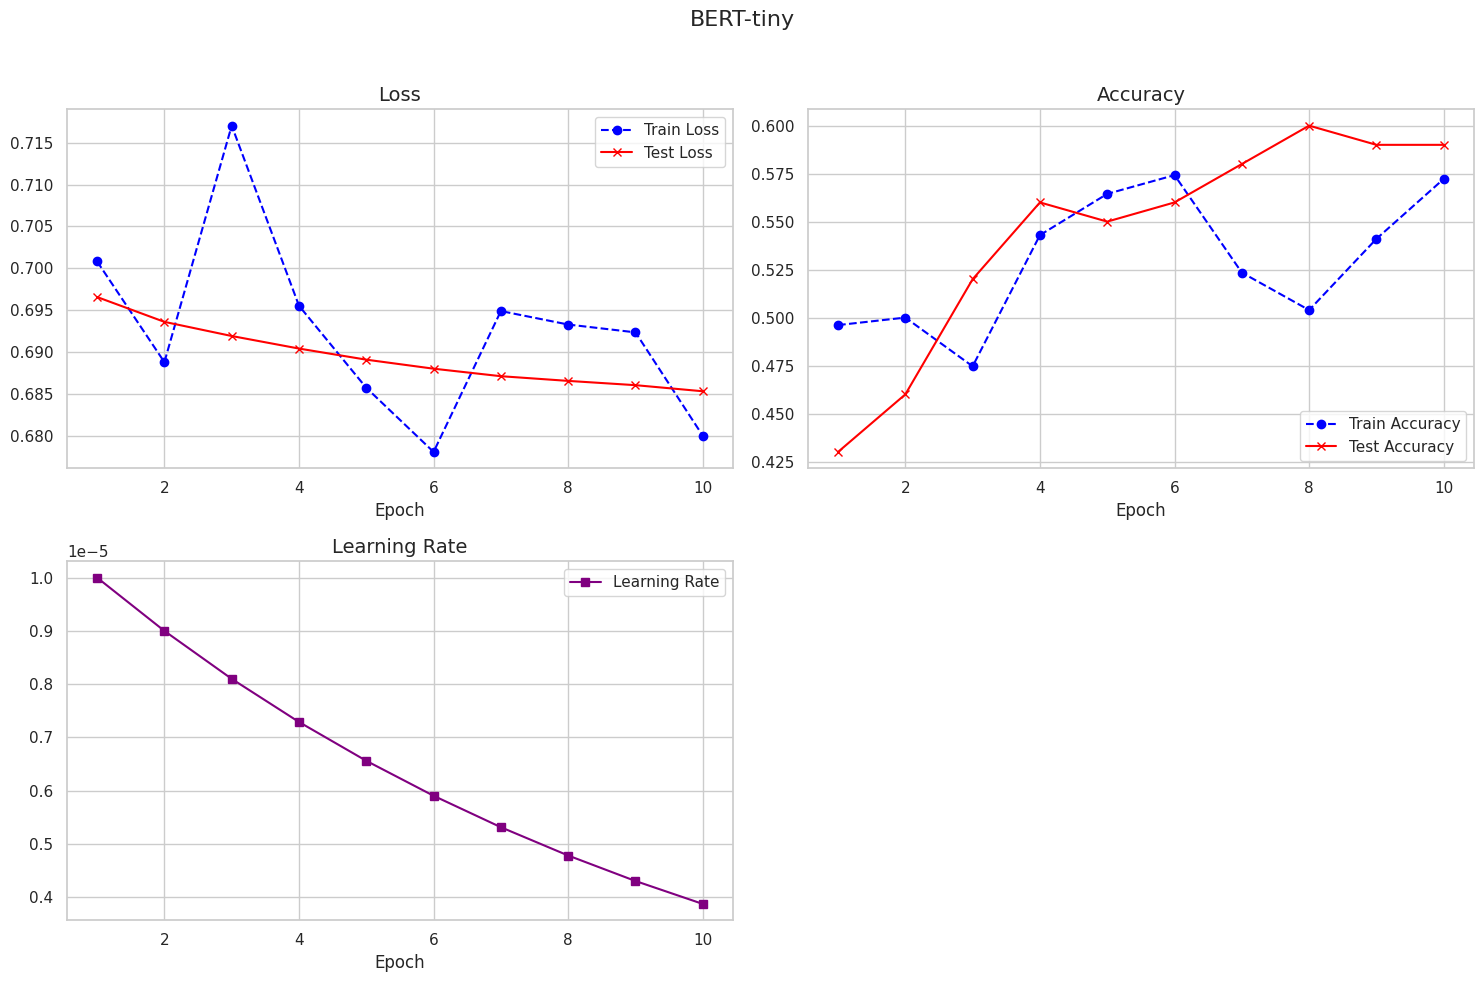

Total Training Time: 47.8s
Overall Accuracy: 0.59


In [ ]:
start_time = time.time()

for epoch in range(n_epochs_bertiny):
    model.train()
    total_train_loss, total_train_accuracy = 0, 0

    current_lr = optimizer.param_groups[0]['lr']
    new_weight_decay = update_WD(current_lr)

    optimizer = torch.optim.AdamW(model.parameters(), lr=current_lr, weight_decay=new_weight_decay)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for batch in train_loader:
        try:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs[0]
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            total_train_accuracy += (outputs[1].argmax(dim=-1) == batch['labels']).float().mean().item()

        except RuntimeError as e:
            if 'could not allocate' in str(e).lower():
                device = torch.device('cpu')
                model.to(device)
            else:
                raise e

    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = new_weight_decay

    model.eval()
    total_test_loss, total_test_accuracy = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs[0]

            total_test_loss += loss.item()
            total_test_accuracy += (outputs[1].argmax(dim=-1) == batch['labels']).float().mean().item()

            all_preds.extend(outputs[1].argmax(dim=-1).cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    train_metrics['Train Loss'].append(total_train_loss / len(train_loader))
    train_metrics['Train Accuracy'].append(total_train_accuracy / len(train_loader))
    test_metrics['Test Loss'].append(total_test_loss / len(test_loader))
    test_metrics['Test Accuracy'].append(total_test_accuracy / len(test_loader))

    hyperparams_metrics['Learning Rate'].append(current_lr)
    hyperparams_metrics['Weight Decay'].append(new_weight_decay)
    hyperparams_metrics['Gradient Clipping'].append(grad_clip)

    live_plot(train_metrics, test_metrics, hyperparams_metrics, title = "BERT-tiny")

end_time = time.time()
total_training_time = end_time - start_time
overall_accuracy = accuracy_score(all_labels, all_preds)

print(f"Total Training Time: {total_training_time:.1f}s")
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# BERT-large

We now try to tune a larger version of BERT in order to compare performance and computational cost.

Since we load the data loaders with tokenizers and we define our optimizer calling the *model* class, we have to load BERT-large tokenizer and sequence classifier and paste the same code snippet afterwards.

Initialize the tokenizer for BERT-large.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

Create data loaders.

In [ ]:
train_dataset = SpeechDataset(train_data['speech'].tolist(), train_data['label'].tolist(), tokenizer)
test_dataset = SpeechDataset(test_data['speech'].tolist(), test_data['label'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

We define the binary classification class as before, but this time with BERT-large.

In [ ]:
class CustomBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config, dropout_prob):
        super().__init__(config)
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return loss, logits

model = CustomBertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2, dropout_prob=dropout_prob)
model.train()
model.to(device)

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomBertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerN

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=l_rate, weight_decay=w_decay)
total_steps = len(train_loader) * n_epochs_bertlarge
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

We need to reset the metrics for plotting.

In [ ]:
train_metrics = {'Train Loss': [], 'Train Accuracy': []}
test_metrics = {'Test Loss': [], 'Test Accuracy': []}
hyperparams_metrics = {'Learning Rate': [], 'Weight Decay': [], 'Gradient Clipping': []}

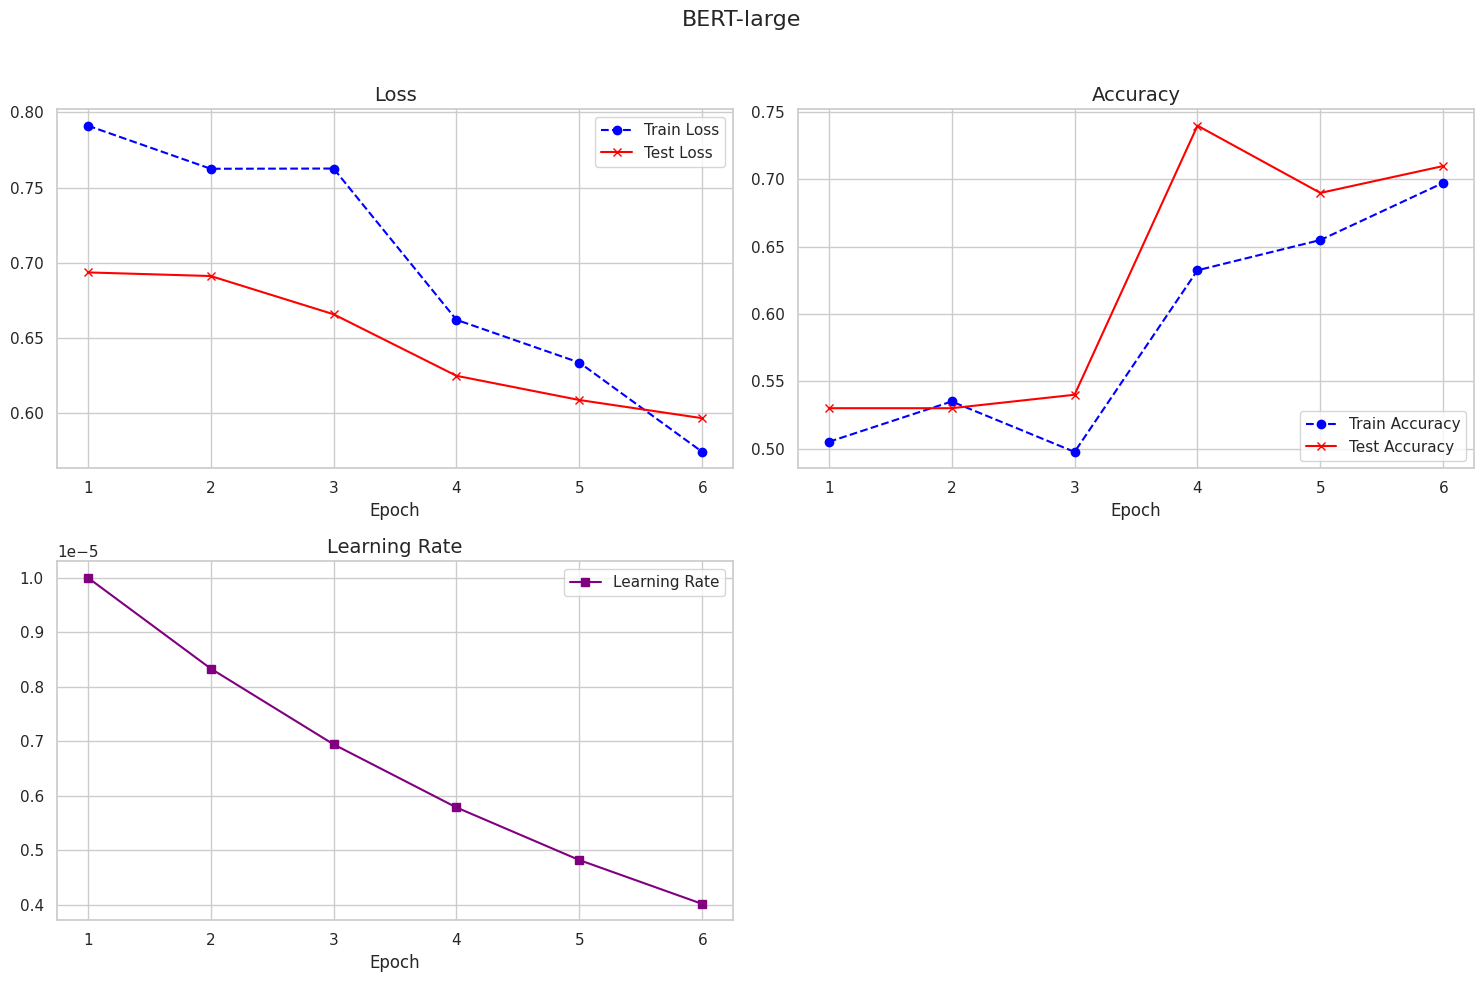

Total Training Time: 182.5s
Overall Accuracy: 0.71


In [ ]:
start_time = time.time()

for epoch in range(n_epochs_bertlarge):
    model.train()
    total_train_loss, total_train_accuracy = 0, 0

    current_lr = optimizer.param_groups[0]['lr']
    new_weight_decay = update_WD(current_lr)

    optimizer = torch.optim.AdamW(model.parameters(), lr=current_lr, weight_decay=new_weight_decay)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for batch in train_loader:
        try:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs[0]
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            total_train_accuracy += (outputs[1].argmax(dim=-1) == batch['labels']).float().mean().item()

        except RuntimeError as e:
            if 'could not allocate' in str(e).lower():
                device = torch.device('cpu')
                model.to(device)
            else:
                raise e

    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = new_weight_decay

    model.eval()
    total_test_loss, total_test_accuracy = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs[0]

            total_test_loss += loss.item()
            total_test_accuracy += (outputs[1].argmax(dim=-1) == batch['labels']).float().mean().item()

            all_preds.extend(outputs[1].argmax(dim=-1).cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    train_metrics['Train Loss'].append(total_train_loss / len(train_loader))
    train_metrics['Train Accuracy'].append(total_train_accuracy / len(train_loader))
    test_metrics['Test Loss'].append(total_test_loss / len(test_loader))
    test_metrics['Test Accuracy'].append(total_test_accuracy / len(test_loader))

    hyperparams_metrics['Learning Rate'].append(current_lr)
    hyperparams_metrics['Weight Decay'].append(new_weight_decay)
    hyperparams_metrics['Gradient Clipping'].append(grad_clip)

    live_plot(train_metrics, test_metrics, hyperparams_metrics, title = "BERT-large")

end_time = time.time()
total_training_time = end_time - start_time
overall_accuracy = accuracy_score(all_labels, all_preds)

print(f"Total Training Time: {total_training_time:.1f}s")
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# RoBERTa

We also try RoBERTa: A Robustly Optimized BERT Pretraining Approach, which is carries the same implementantion as BERT, but uses a byte-level BPE as a tokenizer (same as GPT-2) and uses a different pretraining scheme.

Initialize the tokenizer, the data loaders and the binary classifier.

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_dataset = SpeechDataset(train_data['speech'].tolist(), train_data['label'].tolist(), tokenizer)
test_dataset = SpeechDataset(test_data['speech'].tolist(), test_data['label'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [ ]:
class CustomRobertaForSequenceClassification(RobertaForSequenceClassification):
    def __init__(self, config, dropout_prob):
        super().__init__(config)
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return loss, logits

In [ ]:
model = CustomRobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=2, dropout_prob=dropout_prob)
model.train()
model.to(device)

Some weights of CustomRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=T

Define the optimizer, reset the metrics and run the model.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=l_rate, weight_decay=w_decay)
total_steps = len(train_loader) * n_epochs_roberta
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
train_metrics = {'Train Loss': [], 'Train Accuracy': []}
test_metrics = {'Test Loss': [], 'Test Accuracy': []}
hyperparams_metrics = {'Learning Rate': [], 'Weight Decay': [], 'Gradient Clipping': []}

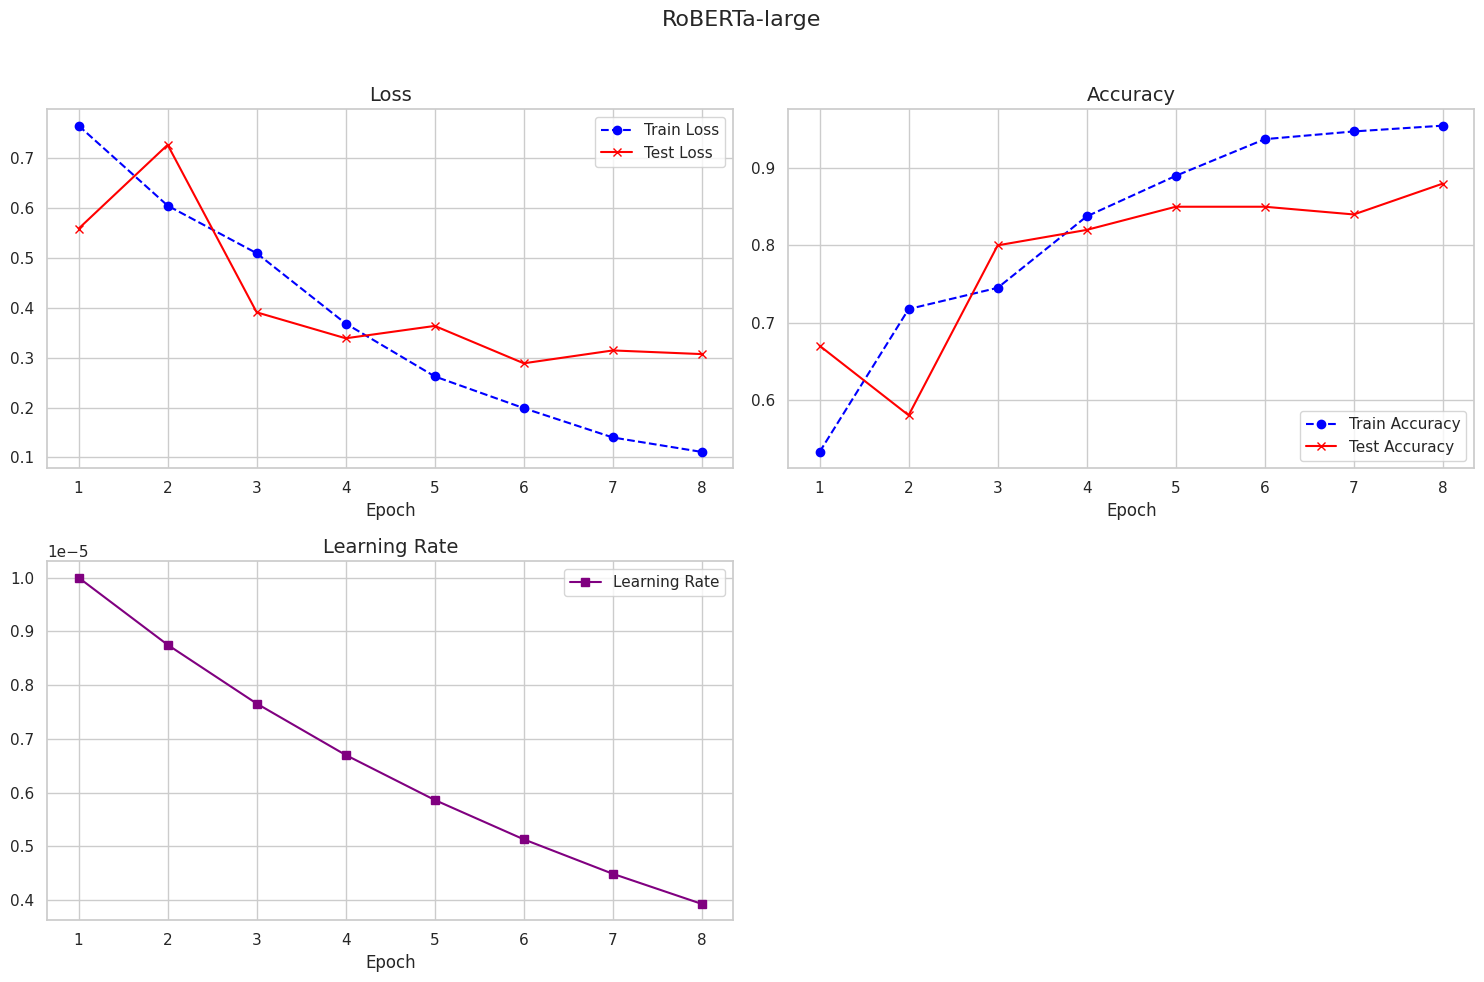

Total Training Time: 253.2s
Overall Accuracy: 0.88


In [ ]:
start_time = time.time()

for epoch in range(n_epochs_roberta):
    model.train()
    total_train_loss, total_train_accuracy = 0, 0

    current_lr = optimizer.param_groups[0]['lr']
    new_weight_decay = update_WD(current_lr)

    optimizer = torch.optim.AdamW(model.parameters(), lr=current_lr, weight_decay=new_weight_decay)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for batch in train_loader:
        try:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs[0]
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            total_train_accuracy += (outputs[1].argmax(dim=-1) == batch['labels']).float().mean().item()

        except RuntimeError as e:
            if 'could not allocate' in str(e).lower():
                device = torch.device('cpu')
                model.to(device)
            else:
                raise e

    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = new_weight_decay

    model.eval()
    total_test_loss, total_test_accuracy = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs[0]

            total_test_loss += loss.item()
            total_test_accuracy += (outputs[1].argmax(dim=-1) == batch['labels']).float().mean().item()

            all_preds.extend(outputs[1].argmax(dim=-1).cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    train_metrics['Train Loss'].append(total_train_loss / len(train_loader))
    train_metrics['Train Accuracy'].append(total_train_accuracy / len(train_loader))
    test_metrics['Test Loss'].append(total_test_loss / len(test_loader))
    test_metrics['Test Accuracy'].append(total_test_accuracy / len(test_loader))

    hyperparams_metrics['Learning Rate'].append(current_lr)
    hyperparams_metrics['Weight Decay'].append(new_weight_decay)
    hyperparams_metrics['Gradient Clipping'].append(grad_clip)

    live_plot(train_metrics, test_metrics, hyperparams_metrics, title = "RoBERTa-large")

end_time = time.time()
total_training_time = end_time - start_time
overall_accuracy = accuracy_score(all_labels, all_preds)

print(f"Total Training Time: {total_training_time:.1f}s")
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# GPT-2
We tried testing a different architecture. In this case, we chose a decoder-only model instead of encoder-only, like BERT-based architectures.

Initialize tokenizer.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
tokenizer.pad_token = tokenizer.eos_token  # as the library suggests we need a padding token

Load data, create binary classifier and load the model.

In [ ]:
train_dataset = SpeechDataset(train_data['speech'].tolist(), train_data['label'].tolist(), tokenizer)
test_dataset = SpeechDataset(test_data['speech'].tolist(), test_data['label'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [ ]:
class CustomGPT2ForSequenceClassification(GPT2ForSequenceClassification):
    def __init__(self, config, dropout_prob):
        super().__init__(config)
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.classifier = torch.nn.Linear(config.n_embd, config.num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.transformer(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return loss, logits

In [ ]:
config = GPT2Config.from_pretrained('gpt2', num_labels=2)
model = CustomGPT2ForSequenceClassification(config, dropout_prob=dropout_prob)
model.train()
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CustomGPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=768, out_features=2, b

Define the optimizer, reset the metrics and run the model.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=l_rate, weight_decay=w_decay)
total_steps = len(train_loader) * n_epochs_GPT
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
train_metrics = {'Train Loss': [], 'Train Accuracy': []}
test_metrics = {'Test Loss': [], 'Test Accuracy': []}
hyperparams_metrics = {'Learning Rate': [], 'Weight Decay': [], 'Gradient Clipping': []}

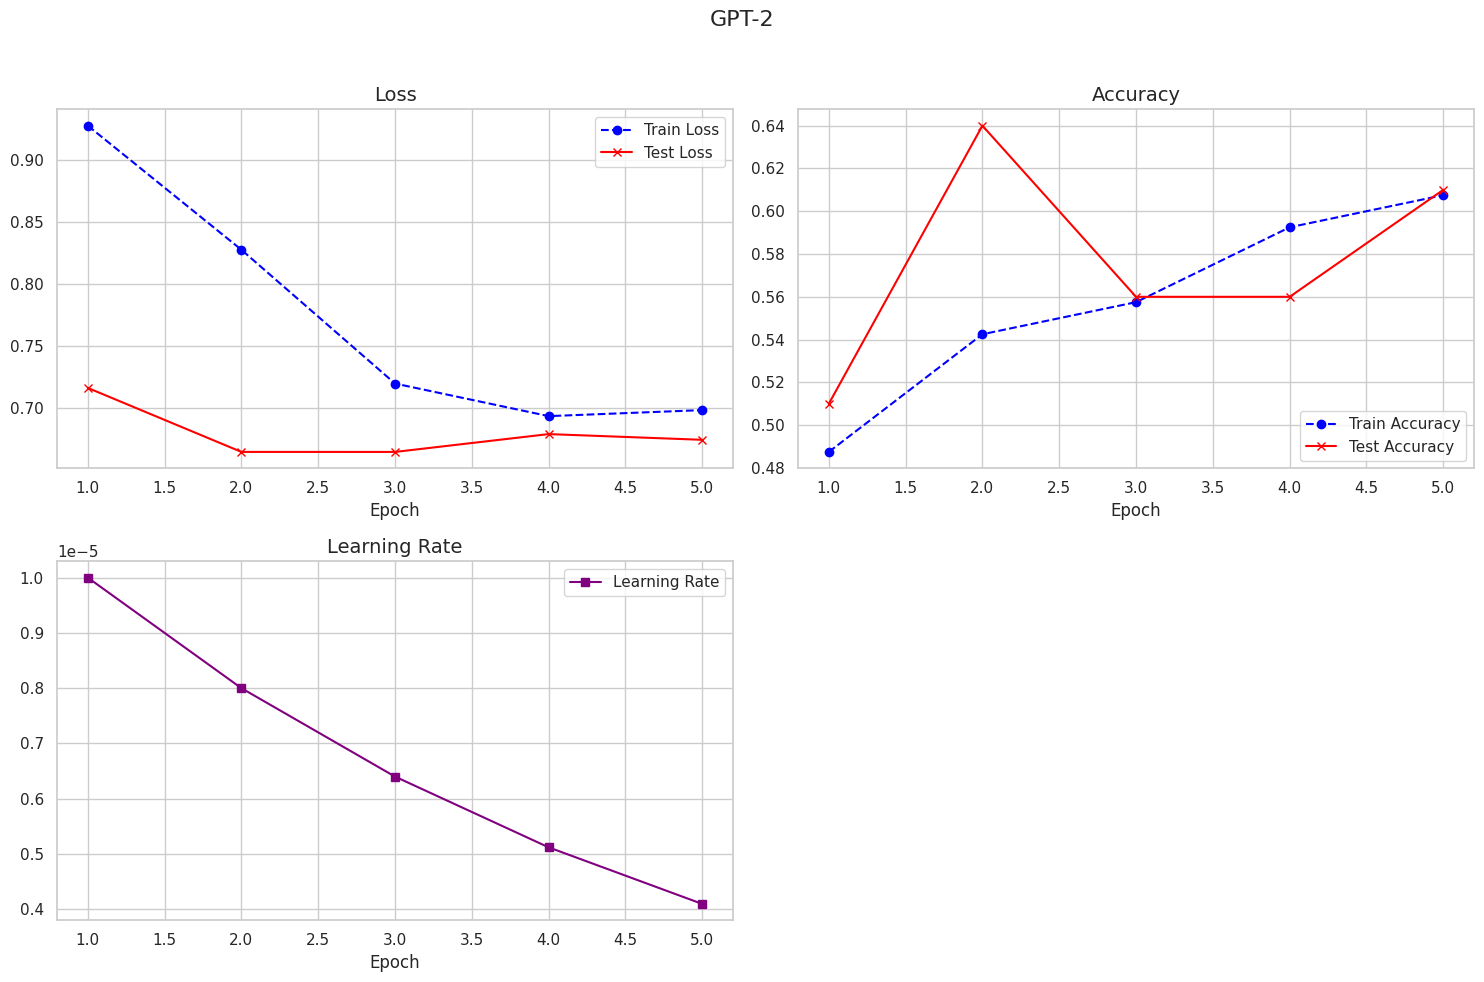

Total Training Time: 65.0s
Overall Accuracy: 0.61


In [ ]:
start_time = time.time()

for epoch in range(n_epochs_GPT):
    model.train()
    total_train_loss, total_train_accuracy = 0, 0

    current_lr = optimizer.param_groups[0]['lr']
    new_weight_decay = update_WD(current_lr)

    optimizer = torch.optim.AdamW(model.parameters(), lr=current_lr, weight_decay=new_weight_decay)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for batch in train_loader:
        try:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs[0]
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            total_train_accuracy += (outputs[1].argmax(dim=-1) == batch['labels']).float().mean().item()

        except RuntimeError as e:
            if 'could not allocate' in str(e).lower():
                device = torch.device('cpu')
                model.to(device)
            else:
                raise e

    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = new_weight_decay

    model.eval()
    total_test_loss, total_test_accuracy = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs[0]

            total_test_loss += loss.item()
            total_test_accuracy += (outputs[1].argmax(dim=-1) == batch['labels']).float().mean().item()

            all_preds.extend(outputs[1].argmax(dim=-1).cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    train_metrics['Train Loss'].append(total_train_loss / len(train_loader))
    train_metrics['Train Accuracy'].append(total_train_accuracy / len(train_loader))
    test_metrics['Test Loss'].append(total_test_loss / len(test_loader))
    test_metrics['Test Accuracy'].append(total_test_accuracy / len(test_loader))

    hyperparams_metrics['Learning Rate'].append(current_lr)
    hyperparams_metrics['Weight Decay'].append(new_weight_decay)
    hyperparams_metrics['Gradient Clipping'].append(grad_clip)

    live_plot(train_metrics, test_metrics, hyperparams_metrics, title = "GPT-2")

end_time = time.time()
total_training_time = end_time - start_time
overall_accuracy = accuracy_score(all_labels, all_preds)

print(f"Total Training Time: {total_training_time:.1f}s")
print(f"Overall Accuracy: {overall_accuracy:.2f}")